In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pp
import pandas as pd
%matplotlib widget

# Requires CSV files to be pre-generated!

In [31]:
#Energy Conversion Table
hartree_to = {
    'hartree' : 1,
    'mH' : 10**3,
    'eV' : 27.2107,	
    'cm-1':	219474.63,	
    'kcal/mol':	627.503,	
    'kJ/mol': 2625.5,
    'K' : 315777,
}

def display_df_with_formats(df, formats):
    # Ensure formats is a dictionary mapping col names to format strings
    fmt_dict = {col: f for col, f in zip(df.columns, formats)}
    # Use DataFrame.style.format for pretty display
    return df.style.format(fmt_dict)
    
def autoscale_ylim(ax,  uselast=True, pad = 0.05):
    """Set y-limits of a matplotlib axis to min/max of all its line data."""
    ymin, ymax = float("inf"), float("-inf")
    for line in ax.get_lines():
        ydata = line.get_ydata()
        ymin = min(ymin, ydata.min())
        if uselast:
            ymax = max(ymax, ydata[-1])
        else:
            ymax = max(ymax, ydata.max())

    if ymin < ymax:  # only update if valid range found
        p = pad * (ymax - ymin)
        ax.set_ylim(ymin - p, ymax + p)

def set_ylim(ax, values, pad = 0.05):
    ylim_min = min(values)
    ylim_range = (values[-1] - ylim_min)
    ylim_max = ylim_min + ylim_range
    ylim_min -= pad * ylim_range
    ylim_max += pad * ylim_range
    ax.set_ylim(ylim_min, ylim_max)

def get_inte(fname, unit='mH', refdist=None):
    df = pd.read_csv(fname,skipinitialspace=True)
    conv_fac = hartree_to[unit]
    for col in df.columns:
        if col == 'DISTANCES': continue
        df[col] = conv_fac * df[col]

    if refdist is None:
        ref_ind = -1
    else:
        # This way, refdist doesn't have to exist in DISTANCES, and
        # nearest neighbor index is given
        ref_ind = (df['DISTANCES'] - refdist).abs().idxmin()
        
    df['Eint'] = df.Etot - df.Etot.values[ref_ind]
    return df
    
def get_common_uncommon(str1, str2):
    # Find the common substring from the start
    prefix = ''
    for a, b in zip(str1, str2):
        if a == b:
            prefix += a
        else:
            break
    common = prefix.rstrip('_')  # Remove trailing underscores

    # Remove common part and any leading/trailing underscores for uncommon parts
    uncommon1 = str1[len(common):].strip('_')
    uncommon2 = str2[len(common):].strip('_')
    return common, uncommon1, uncommon2

def add_difference_columns(df: pd.DataFrame, col_pairs: list[tuple[str, str]]) -> pd.DataFrame:
    df = df.copy()
    for col1, col2 in col_pairs:
        common, uncommon1, uncommon2 = get_common_uncommon(col1, col2)
        new_col = f"Del_{common}_{uncommon1}_{uncommon2}"
        df[new_col] = df[col2] - df[col1]
    return df

def save_styled_df_to_csv(df, formats, filename):
    # Apply formatting
    fmt_dict = {col: f for col, f in zip(df.columns, formats)}
    # Get the rendered DataFrame as string with formatting applied
    formatted_df = df.copy()
    for col, fmt in fmt_dict.items():
        formatted_df[col] = formatted_df[col].map(lambda x: fmt.format(x))
    # Save to CSV without the index
    formatted_df.to_csv(filename, index=False)
    
unit='mH'
refdist = None
df_std = get_inte(
    'cu_nh3/standard/standard_gamma_1.9_r_all.csv', unit=unit,
    refdist=refdist
)
df_std_qz = get_inte(
    'cu_nh3/standard_QZ/standard_gamma_1.9_r_all_QZ.csv', unit=unit,
    refdist=refdist
)
df_xg = get_inte(
    'cu_nh3/xg/xg_2.40_1.40_1.90_r_all.csv', 
    unit=unit,
    refdist=refdist
)

dfs_and_suffixes = [
    (df_std, '_std'),  
    (df_std_qz, '_std_qz'),
    (df_xg, '_xg')
]

merged_df = dfs_and_suffixes[0][0]
suff = dfs_and_suffixes[0][1]
merged_df.columns = merged_df.columns.map(lambda x: str(x) + suff if x != 'DISTANCES' else x) 
for df, suff in dfs_and_suffixes[1:]:
    df.columns = df.columns.map(lambda x: str(x) + suff if x != 'DISTANCES' else x)
    print(suff)
    merged_df =  pd.merge(
            merged_df, df, on=['DISTANCES'],
            how='outer'
    ) 
    

#cols_to_display = 'DISTANCES Ecorr_std Eint_std Ecorr_std_qz Eint_std_qz Ecorr_xg Eint_xg'.split()

summary_df = merged_df#[cols_to_display]

diffs = [
    ('Ecorr_std', 'Ecorr_std_qz'), 
    ('Ecorr_std', 'Ecorr_xg'),
]
summary_df = add_difference_columns(summary_df, diffs)
formats = ['{:.2f}'] * len(summary_df.columns)
outdf = display_df_with_formats(summary_df, formats)
save_styled_df_to_csv(summary_df, formats, 'summary_of_ener_cu_nh3.csv')

_std_qz
_xg


In [10]:
sorted(summary_df.columns)

['DISTANCES',
 'Del_Ecorr_std__qz',
 'Del_Ecorr_std_xg',
 'Ecorr_std',
 'Ecorr_std_qz',
 'Ecorr_xg',
 'Eint_std',
 'Eint_std_qz',
 'Eint_xg']

## Plot them

In [15]:
def get_labels(prefix, suffixes):
    return [
        fr"${prefix}_{{{suffix.replace('_',"")}}}$" for suffix in suffixes
    ]

<>:71: SyntaxWarning: invalid escape sequence '\A'
<>:71: SyntaxWarning: invalid escape sequence '\A'
/SCR1/amin/ipykernel_3441198/2504562748.py:71: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel("Distances $\AA$")


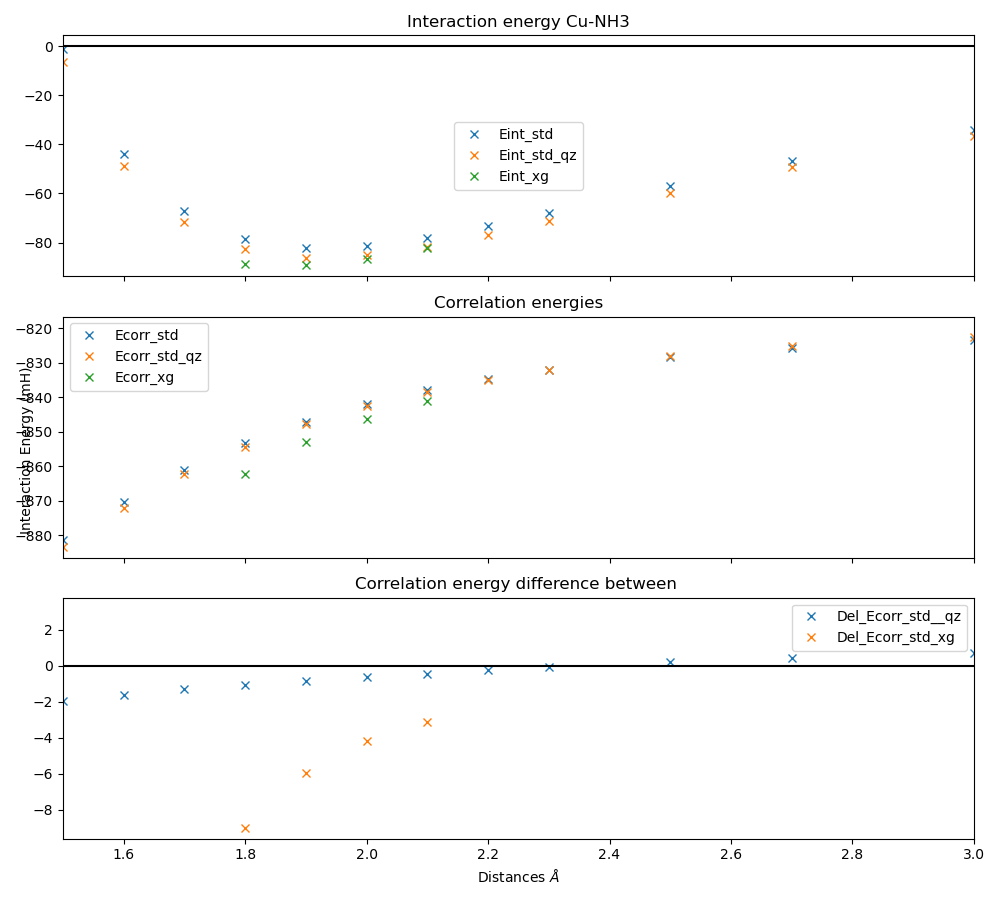

In [23]:
#fig, axes = pp.subplots(3,1, sharex=True)
fig, axes = pp.subplots(
    nrows=3, ncols=1,
    figsize=(10, 9),
    #gridspec_kw={'width_ratios': [4, 1]},
    sharex='all'  # or sharex=True, both work
)

df = summary_df
suffixes = ['_std', 'std_qz', '_xg']

# Interaction energy
ax = axes[0]#, 0]

ax.set_title("Interaction energy Cu-NH3")
df.plot(
    x='DISTANCES', y=[
            'Eint_std',
            'Eint_std_qz',
            'Eint_xg'
 ], 
    marker='x', linewidth=0, ax=ax
)
autoscale_ylim(ax)
ax.axhline(0, color='k')

'''
handles, labels = ax.get_legend_handles_labels()
axes[0, 1].legend(
    handles, labels, loc='center', frameon=False
)
'''
#ax.legend(
#    labels=get_labels('E^{{int}}', suffixes))#[fr"$E^{{int}}_{{{suffixes[1]}}}$", fr"$E^{{int}}_{{{suffixes[0]}}}$"])

# Difference in interaction energy
ax = axes[1]#, 0]

ax.set_title("Correlation energies")
df.plot(
    x='DISTANCES', y=[
        'Ecorr_std',
        'Ecorr_std_qz',
        'Ecorr_xg',
    ], marker='x', linewidth=0, ax=ax, 
)
autoscale_ylim(ax, uselast=False)
ax.axhline(0, color='k')

'''
handles, labels = ax.get_legend_handles_labels()
axes[1, 1].legend(
    handles, labels, loc='center', frameon=False
)
'''
#ax.legend(labels=get_labels('E^{{corr}}', suffixes))#[fr"$E^{{int}}_{{{suffixes[1]}}}$", fr"$E^{{int}}_{{{suffixes[0]}}}$"])


# Difference in Total energy
ax = axes[2]#, 0]


ax.set_title(
    f"Correlation energy difference between "
)
df.plot(
    x='DISTANCES', y=[ 'Del_Ecorr_std__qz',
 'Del_Ecorr_std_xg',], marker='x', linewidth=0, ax=ax, ylabel=None
)
ax.set_xlim(1.5, 3)
ax.set_xlabel("Distances $\AA$")
fig.text(0.02, 0.5, f"Interaction Energy ({unit})", va="center", rotation="vertical")

autoscale_ylim(ax, uselast=False)
ax.axhline(0, color='k')

'''
handles, labels = ax.get_legend_handles_labels()
axes[2, 1].legend(
    handles, labels, loc='center', frameon=False
)
'''
#ax.legend(labels=['STD vs STD_QZ', 'STD vs XG'])#[fr"$E^{{int}}_{{{suffixes[1]}}}$", fr"$E^{{int}}_{{{suffixes[0]}}}$"])
fig.tight_layout()

In [32]:
colord = ['DISTANCES'] + [col for col in sorted(summary_df.columns[1:], reverse=True)]
summary_df[colord]

,DISTANCES,Etot_xg,Etot_std_qz,Etot_std,Eint_xg,Eint_std_qz,Eint_std,Ecorr_xg,Ecorr_std_qz,Ecorr_std,Del_Ecorr_std_xg,Del_Ecorr_std__qz
0,1.5,NaN,-1695781.305,-1695773.953,NaN,-6.306,-1.007,NaN,-883.207,-881.248,NaN,-1.959
1,1.6,NaN,-1695823.789,-1695816.884,NaN,-48.790,-43.938,NaN,-871.976,-870.367,NaN,-1.609
2,1.7,NaN,-1695846.782,-1695840.258,NaN,-71.783,-67.312,NaN,-862.353,-861.036,NaN,-1.317
3,1.8,-1695860.471,-1695857.677,-1695851.476,-88.626,-82.678,-78.530,-862.311,-854.376,-853.315,-8.996,-1.061
4,1.9,-1695861.157,-1695861.164,-1695855.226,-89.312,-86.165,-82.280,-852.980,-847.884,-847.050,-5.930,-0.834
5,2.0,-1695858.640,-1695860.204,-1695854.482,-86.795,-85.205,-81.536,-846.168,-842.637,-842.011,-4.157,-0.626
6,2.1,-1695854.240,-1695856.671,-1695851.133,-82.395,-81.672,-78.187,-841.077,-838.406,-837.970,-3.107,-0.436
7,2.2,NaN,-1695851.750,-1695846.374,NaN,-76.751,-73.428,NaN,-834.990,-834.729,NaN,-0.261
8,2.3,NaN,-1695846.181,-1695840.957,NaN,-71.182,-68.011,NaN,-832.218,-832.123,NaN,-0.095
9,2.5,NaN,-1695834.771,-1695829.820,NaN,-59.772,-56.874,NaN,-828.108,-828.300,NaN,0.192


In [30]:
df = summary_df[colord]
df.to_csv('cu_nh3_interaction.csv', index=False)

In [28]:
fig.savefig("cu_nh3_interaction.svg")

In [ ]:
ax.set_xlim(2.5,6)

## Generate new distances manually


In [ ]:
df.DISTANCES.values

In [ ]:
tol = 0.0001
start = 3.0
mid = 4.8
end = 6.0
tail = 10.0
dists = np.concatenate(
    [np.arange(start, mid-tol, 0.1),
    np.arange(mid, end-tol, 0.4),
    np.arange(end, tail-tol, 1.0)]
)
print('['+','.join(f"{r:3.1f}" for r in dists)+']')

In [ ]:
df